In [93]:
%load_ext autoreload
%autoreload 2

import sys
import json
from datetime import datetime, timedelta
import requests
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',80)
pd.set_option('display.precision',2)

%matplotlib inline
plt.style.use('seaborn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#from sklearn import metrics
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.feature_selection import RFECV

## Reading data

In [69]:
target_col = 'Survived'
train = pd.read_csv("train.csv")
train['family_size'] = train['Parch']+train['SibSp']+1
train['family_bin'] = pd.cut(train.family_size, [0,1.5,2.5, 20], labels=['1','2', '>=3'])
train_survived = train.query(f"{target_col}==1")
train_dead = train.query(f"{target_col}==0") 
fullColumns = train.columns
# check for general information on data
train.shape
train.head()

# PassengerId is a unique id which has no meaning
# Survived is target variables.
drop_cols = ['PassengerId', 'Survived']
train_dropped = train.drop(columns=drop_cols)
train_dropped.columns

(891, 14)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,family_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.28,C85,C,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S,1,1


Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'family_size', 'family_bin'],
      dtype='object')

In [4]:
train.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


## Exploratory data analysis (EDA)
- show basic stats (describe), type and nulss (info)
- type conversion, if needed
- whether target variable is balanced or not
- check for missing values and possible outliner
- categorical variables:
 - for category, plot ratio of target values per class.
 - or check sns.catplot
 - for categorical features with many categories and some categories with low occurance?
- numerical variables
 - first check correlation of features with target variables
 - for low correlation features, can further compare distribution per class or
- text features
- picture features

In [5]:
# check statistics for numerical features
train.describe()

# data type and number of non-null values
# it appears age, embared need to be filled / imputed
# Cabin has two many null values. May be removed/dropped
train.info()

# check whether target classes are balanced or not
train.Survived.value_counts()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


0    549
1    342
Name: Survived, dtype: int64

### Check categorical variables
- survival rate for each categorical feature
- visualize

Pclass


Survived,0,1,survive_rate
Pclass,,,
1,80,136,0.63
2,97,87,0.47
3,372,119,0.24


Text(0.5, 1.0, 'Pclass vs. Survived')

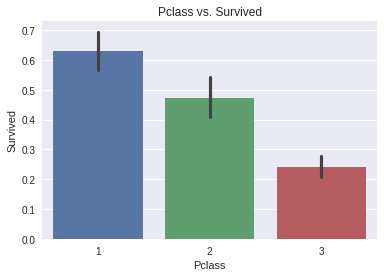

In [6]:
# Pclass appears to be a good feature
col = 'Pclass'
print(col)
survival_rate = pd.crosstab(train[col], train.Survived).assign(survive_rate=lambda x: x[1]/(x.sum(axis=1)))
survival_rate

fig, ax = plt.subplots(1,1)
sns.barplot(data=train, x=col, y=target_col, ax=ax)
ax.set_title(f"{col} vs. {target_col}")

Sex


Survived,0,1,survive_rate
Sex,,,
female,81,233,0.74
male,468,109,0.19


Text(0.5, 1.0, 'Sex vs. Survived')

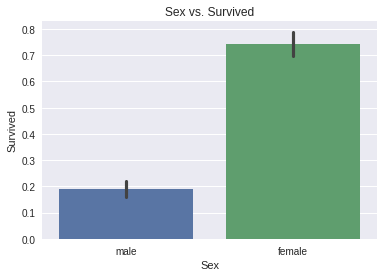

In [7]:
# Sex also a good indicator
col = 'Sex'
print(col)
survival_rate = pd.crosstab(train[col], train.Survived).assign(survive_rate=lambda x: x[1]/(x.sum(axis=1)))
survival_rate

fig, ax = plt.subplots(1,1)
sns.barplot(data=train, x=col, y=target_col, ax=ax)
ax.set_title(f"{col} vs. {target_col}")

Embarked


Survived,0,1,survive_rate
Embarked,,,
C,75,93,0.55
Q,47,30,0.39
S,427,217,0.34


Text(0.5, 1.0, 'Embarked vs. Survived')

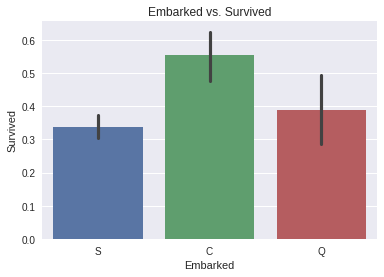

In [8]:
# Embarked
col = 'Embarked'
print(col)
survival_rate = pd.crosstab(train[col], train.Survived).assign(survive_rate=lambda x: x[1]/(x.sum(axis=1)))
survival_rate

fig, ax = plt.subplots(1,1)
sns.barplot(data=train, x=col, y=target_col, ax=ax)
ax.set_title(f"{col} vs. {target_col}")

### Check numerical variables
- visualize distribution

In [9]:
train.Age.describe()

count    714.00
mean      29.70
std       14.53
min        0.42
25%       20.12
50%       28.00
75%       38.00
max       80.00
Name: Age, dtype: float64

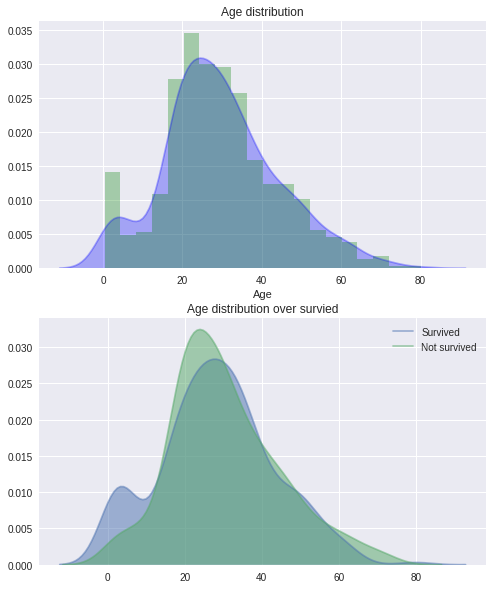

In [22]:
# Age, lower survival rate for young adults (15-30) and older person (60+)
# higher survival rate for baby (<10)
col = 'Age'
fig, axes = plt.subplots(2, 1, figsize=(8, 10));
sns.distplot(train[col].dropna(), hist_kws={"alpha": 0.3, "color":'g'}, kde_kws={"shade": True, "alpha": 0.3, "color":'b'}, ax=axes[0]);
axes[0].set_title('Age distribution');
bounds = [np.floor(train.Age.min()), np.ceil(train.Age.max())]
sns.kdeplot(train_survived[col], shade=True, alpha=0.5, ax=axes[1], label='Survived');
sns.kdeplot(train_dead[col], shade=True, alpha=0.5, ax=axes[1], label='Not survived');
axes[1].set_title(f'{col} distribution over survied');
#axes[1].legend()

In [113]:
for n_bins in range(4, 8):
    train['age_bin'] = pd.cut(train.Age, n_bins)
    col = 'age_bin'
    survival_rate = pd.crosstab(train[col], train.Survived).assign(survive_rate=lambda x: x[1]/(x.sum(axis=1)))
    survival_rate.survive_rate
    n_bins, sp.stats.entropy(survival_rate.survive_rate.values)

age_bin
(0.34, 20.315]     0.46
(20.315, 40.21]    0.40
(40.21, 60.105]    0.39
(60.105, 80.0]     0.23
Name: survive_rate, dtype: float64

(4, 1.356941273261696)

age_bin
(0.34, 16.336]      0.55
(16.336, 32.252]    0.37
(32.252, 48.168]    0.40
(48.168, 64.084]    0.43
(64.084, 80.0]      0.09
Name: survive_rate, dtype: float64

(5, 1.5032580886119187)

age_bin
(0.34, 13.683]      0.59
(13.683, 26.947]    0.35
(26.947, 40.21]     0.43
(40.21, 53.473]     0.39
(53.473, 66.737]    0.35
(66.737, 80.0]      0.14
Name: survive_rate, dtype: float64

(6, 1.7240515052910201)

age_bin
(0.34, 11.789]      0.57
(11.789, 23.157]    0.36
(23.157, 34.526]    0.40
(34.526, 45.894]    0.42
(45.894, 57.263]    0.41
(57.263, 68.631]    0.35
(68.631, 80.0]      0.14
Name: survive_rate, dtype: float64

(7, 1.8909721755336573)

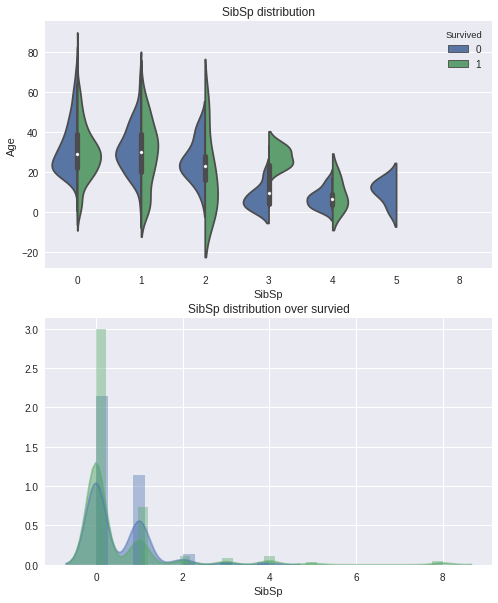

In [42]:
# SibSp, lower survival rate for young adults (15-30) and older person (60+)
# higher survival rate for baby (<10)
col = 'SibSp'
fig, axes = plt.subplots(2, 1, figsize=(8, 10));
sns.violinplot(data=train, x=col, y='Age', hue=target_col, split=True, ax=axes[0]);
axes[0].set_title(f'{col} distribution');
bounds = [np.floor(train.Age.min()), np.ceil(train.Age.max())]
sns.distplot(train_survived[col], kde_kws=dict(shade=True, alpha=0.5), ax=axes[1], label='Survived');
sns.distplot(train_dead[col], hist_kws=dict(density=True), kde_kws=dict(shade=True, alpha=0.5), ax=axes[1], label='Not survived');
#axes[1].hist(train_survived[col], density=True, alpha=0.5, label='survived')
#axes[1].hist(train_dead[col], density=True, alpha=0.5, label='Not survived')
#axes[1].legend()
axes[1].set_title(f'{col} distribution over survied');
#axes[1].legend()

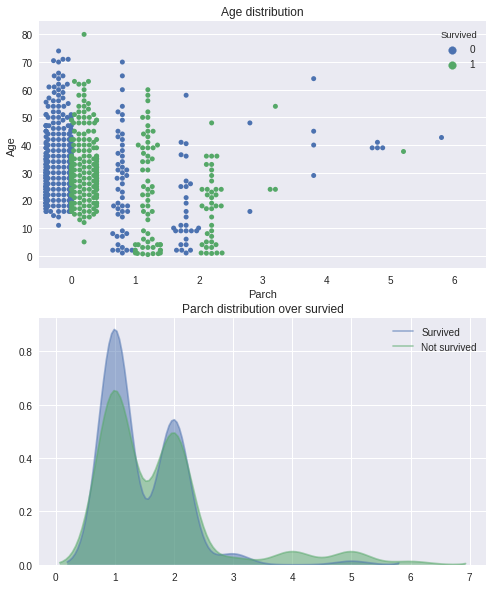

In [13]:
# Parch, lower survival rate for Parch>=3
col = 'Parch'
fig, axes = plt.subplots(2, 1, figsize=(8, 10));
sns.swarmplot(data=train, x=col, y='Age', hue=target_col, dodge=True, ax=axes[0]);
axes[0].set_title('Age distribution');
bounds = [np.floor(train.Age.min()), np.ceil(train.Age.max())]
sns.kdeplot(train_survived[col], shade=True, alpha=0.5, clip=bounds, ax=axes[1], label='Survived');
sns.kdeplot(train_dead[col], shade=True, alpha=0.5, clip=bounds, ax=axes[1], label='Not survived');
axes[1].set_title(f'{col} distribution over survied');
#axes[1].legend()

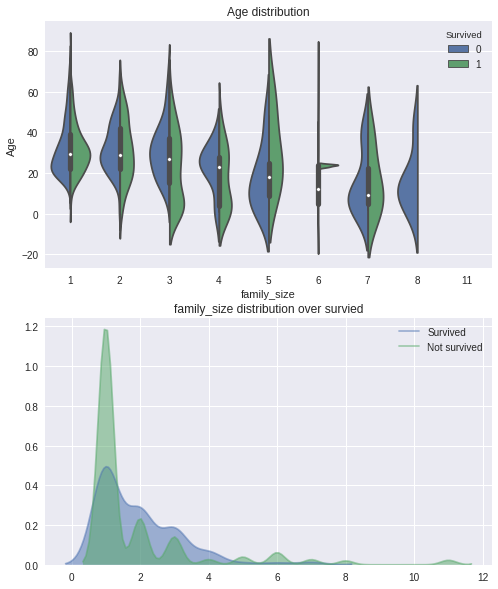

In [71]:
# Check family size (Parch+SibSp)+1,
# lower survival rate for young adults (15-30) and older person (60+)
# higher survival rate for baby (<10)
col = 'family_size'
fig, axes = plt.subplots(2, 1, figsize=(8, 10));
sns.violinplot(data=train, x=col, y='Age', hue=target_col, split=True, ax=axes[0]);
axes[0].set_title('Age distribution');
bounds = [np.floor(train.Age.min()), np.ceil(train.Age.max())]
sns.kdeplot(train_survived[col], shade=True, alpha=0.5, clip=bounds, ax=axes[1], label='Survived');
sns.kdeplot(train_dead[col], shade=True, alpha=0.5, clip=bounds, ax=axes[1], label='Not survived');
axes[1].set_title(f'{col} distribution over survied');
#axes[1].legend()

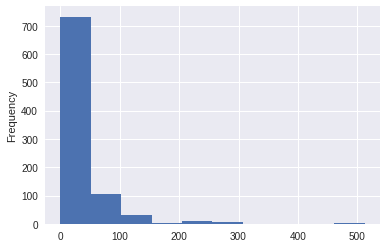

In [78]:
#train.family_size.value_counts().sort_index()
#pd.cut(train.family_size, [0,1.5,2.5, 20], labels=['1','2', '>=3']).value_counts()
#train.SibSp.value_counts()
#train.Parch.value_counts()
#train.Age.value_counts()
train.Fare.plot.hist()
#train.Cabin.value_counts()

In [15]:
# further exploration
train.columns
drop_cols = ['PassengerId', 'Cabin']
# categorical values
#?: how to handle SibSp and Parch
cat_cols = ['Pclass', 'Sex', 'SibSp', 'Parch',  'Embarked']
for col in cat_cols:
    survival_rate = pd.crosstab(train[col], train.Survived).assign(survive_rate=lambda x: x[1]/(x.sum(axis=1)))
    survival_rate
    #plt.figure(); survival_rate.survive_rate.plot.bar();
    #plt.title(f"{col} vs. Survival_rate");


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Survived,0,1,survive_rate
Pclass,,,
1,80,136,0.63
2,97,87,0.47
3,372,119,0.24


Survived,0,1,survive_rate
Sex,,,
female,81,233,0.74
male,468,109,0.19


Survived,0,1,survive_rate
SibSp,,,
0,398,210,0.35
1,97,112,0.54
2,15,13,0.46
3,12,4,0.25
4,15,3,0.17
5,5,0,0.00
8,7,0,0.00


Survived,0,1,survive_rate
Parch,,,
0,445,233,0.34
1,53,65,0.55
2,40,40,0.50
3,2,3,0.60
4,4,0,0.00
5,4,1,0.20
6,1,0,0.00


Survived,0,1,survive_rate
Embarked,,,
C,75,93,0.55
Q,47,30,0.39
S,427,217,0.34


In [16]:
# numerical values
# keep it as is or divide into bins
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#sns.heatmap(train[['Survived']+num_cols].corr(), annot=True, fmt = ".2f", cmap="coolwarm", ax=ax);
train[['Survived']+num_cols].corr()

"""for col in num_cols:
    survived_dist = pd.crosstab(train[col], train.Survived)
    plt.figure(); survived_dist.plot.kde();
    _=plt.title(f"KDE of {col}");"""


,Survived,Age,Fare,SibSp,Parch
Survived,1.00,-0.08,0.26,-0.04,0.08
Age,-0.08,1.00,0.10,-0.31,-0.19
Fare,0.26,0.10,1.00,0.16,0.22
SibSp,-0.04,-0.31,0.16,1.00,0.41
Parch,0.08,-0.19,0.22,0.41,1.00


'for col in num_cols:\n    survived_dist = pd.crosstab(train[col], train.Survived)\n    plt.figure(); survived_dist.plot.kde();\n    _=plt.title(f"KDE of {col}");'

In [17]:
# more investigation required
other_cols = ['Name', 'Ticket', 'Cabin']


## Feature engineering